# Fraud detection project
Fraud is a major problem in many industries, costing companies and individuals billions of dollars every year. Detecting and preventing fraud is a challenging task, as fraudsters are constantly evolving their tactics and finding new ways to exploit weaknesses in the system. However, with the increasing availability of data and advances in machine learning techniques, it is possible to develop effective fraud detection models that can identify fraudulent behavior in real-time.

In this project, we aim to develop a fraud detection system using machine learning algorithms. Our goal is to build a model that can accurately identify fraudulent transactions while minimizing false positives, which can lead to unnecessary investigation costs and loss of legitimate customers. We will use historical transaction data to train our model, and test it on new data to evaluate its performance.

The dataset that will be used is [fraud-transaction-detection with ANN](https://www.kaggle.com/code/chaitnyapol/fraud-transaction-detection-with-ann), quite a large dataset and its size means it comes with some challenges, but benefits as well.


In [6]:
import pandas as pd 
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt


In [2]:
df = pd.read_csv("fraud.csv")
df.head()

,Unnamed: 0,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO
0,0,0,2023-01-01 00:00:31,596,3156,533.07,31,0,0,0
1,1,1,2023-01-01 00:02:10,4961,3412,808.56,130,0,0,0
2,2,2,2023-01-01 00:07:56,2,1365,1442.94,476,0,1,1
3,3,3,2023-01-01 00:09:29,4128,8737,620.65,569,0,0,0
4,4,4,2023-01-01 00:10:34,927,9906,490.66,634,0,0,0


We'll drop some of these columns and we'll see what we can find out about the rest of the dataset. The columns that are dropped are unnamed, transaction_id (because they seem to be just index columns), as well as tx_fraud_scenario that is a duplicate of tx_fraud.

In [4]:
df = df.drop(['Unnamed: 0', 'TRANSACTION_ID', 'TX_FRAUD_SCENARIO'], axis=1)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1754155 entries, 0 to 1754154
Data columns (total 7 columns):
 #   Column           Dtype  
---  ------           -----  
 0   TX_DATETIME      object 
 1   CUSTOMER_ID      int64  
 2   TERMINAL_ID      int64  
 3   TX_AMOUNT        float64
 4   TX_TIME_SECONDS  int64  
 5   TX_TIME_DAYS     int64  
 6   TX_FRAUD         int64  
dtypes: float64(1), int64(5), object(1)
memory usage: 93.7+ MB


# Data exploration
Before building a fraud detection model, it is essential to understand the data and gain insights into the patterns and characteristics of fraudulent transactions. In this segment of the project, we will explore the dataset to identify potential features and trends that can help us detect fraud.

Our dataset consists of transaction records, including information such as transaction amount, transaction date and time, customer ids, and the terminal used. We will start by examining the distribution of these variables, looking for anomalies and outliers that may indicate fraudulent behavior.

Next, we will examine the correlation between the features and the target variable, which in this case is whether a transaction is fraudulent or not. We will use a correlation matrix.

We will also explore the temporal aspect of the data, looking for patterns and trends in the transaction time series. We will examine the frequency and timing of transactions to identify potential patterns that may indicate fraudulent behavior, such as a sudden increase in transaction volume or a spike in transactions during off-hours.

In [23]:
df['TX_FRAUD'].value_counts()

0    1518186
1     235969
Name: TX_FRAUD, dtype: int64

It can be seen that about 13.5% of the data is fraudulent, which seems high but is not unlikely.

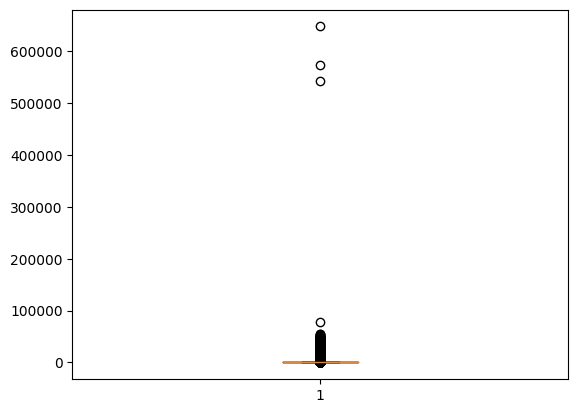

In [15]:
import matplotlib.pyplot as plt

plt.boxplot(df['TX_AMOUNT'])
plt.show()

From this, we can definitely see there are some outliers, that might be either fraudulent transactions, or just very large, hard to tell at this point. Other than that, the data seems to be focused.

C:\Users\vojislav\AppData\Local\Temp\ipykernel_11832\2653723536.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


<AxesSubplot: >

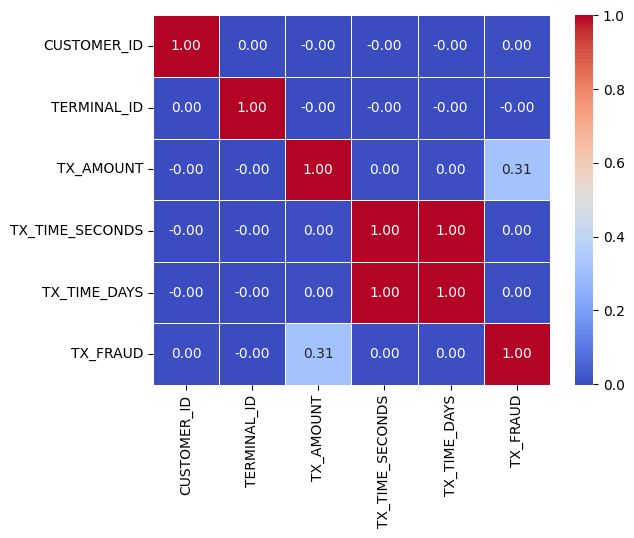

In [18]:
corr = df.corr()

sns.heatmap(corr, linewidths=.5, cmap='coolwarm', annot=True, fmt='.2f')

We can be sure to assume that a high transaction amount is correlated with the fact that the transaction is actually fraudulent.

In [28]:
df['TX_DATETIME'] = pd.to_datetime(df['TX_DATETIME'])

df['dayOfWeek'] = df['TX_DATETIME'].dt.dayofweek
df['monthOfYear'] = df['TX_DATETIME'].dt.month
df['weekOfYear'] = df['TX_DATETIME'].dt.isocalendar().week


Text(0, 0.5, 'Transaction Amount')

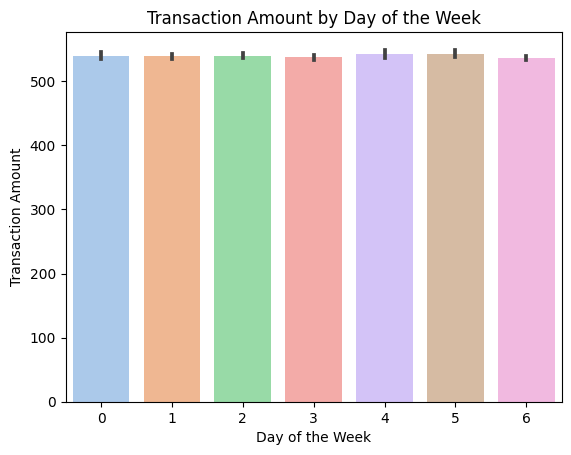

In [30]:
fig, ax = plt.subplots()

sns.barplot(x='dayOfWeek', y='TX_AMOUNT', data=df, palette='pastel')

plt.title('Transaction Amount by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Transaction Amount')

Text(0, 0.5, 'Transaction Amount')

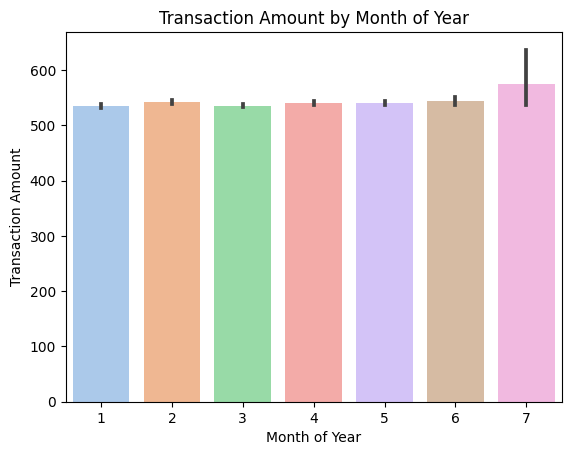

In [31]:
fig, ax = plt.subplots()

sns.barplot(x='monthOfYear', y='TX_AMOUNT', data=df, palette='pastel')

plt.title('Transaction Amount by Month of Year')
plt.xlabel('Month of Year')
plt.ylabel('Transaction Amount')

Text(0, 0.5, 'Transaction Amount')

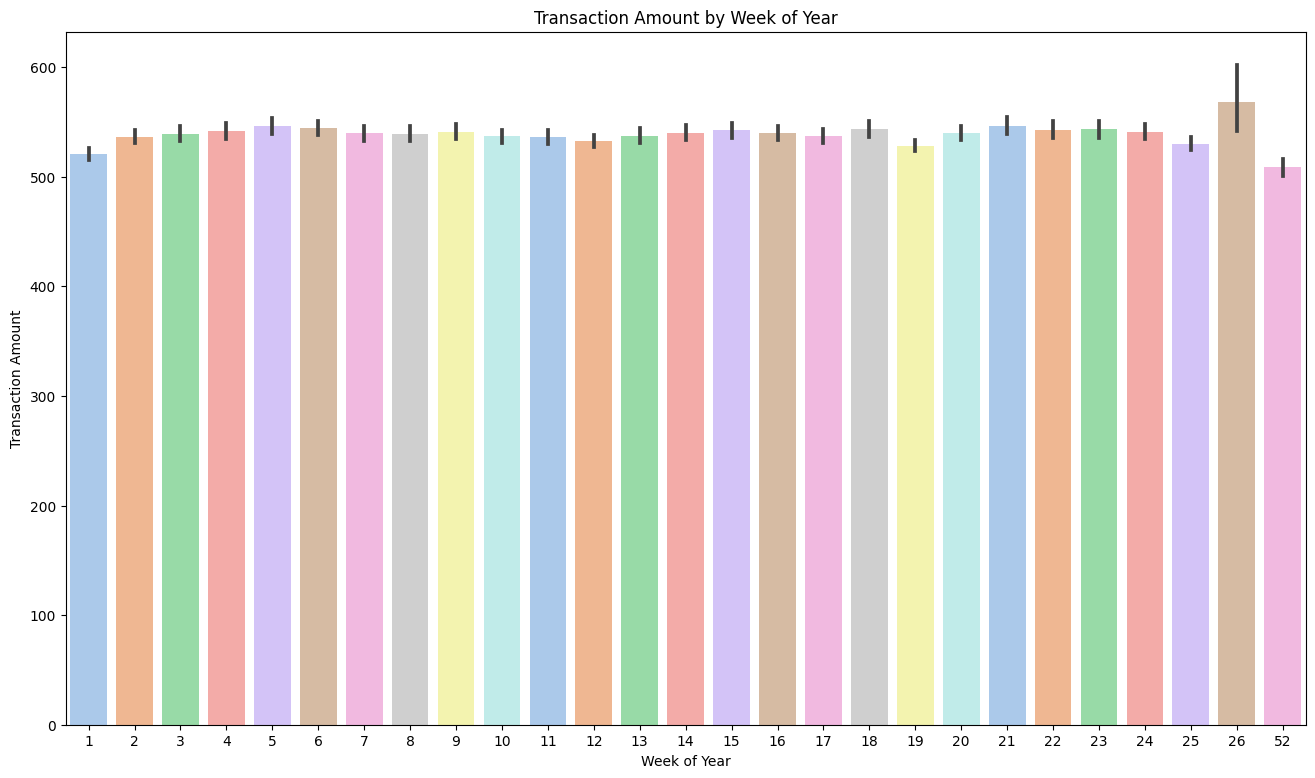

In [33]:
fig, ax = plt.subplots(figsize=(16,9))

sns.barplot(x='weekOfYear', y='TX_AMOUNT', data=df, palette='pastel')

plt.title('Transaction Amount by Week of Year')
plt.xlabel('Week of Year')
plt.ylabel('Transaction Amount')

It seems that there is a higher chance that there's a fraudulent transaction in the last week of the dataset. (Week 52 is actually week 0, for some reason it is formatted in a weird way)

# Model
Now that we've had an overlook of the data, we can test out a simple Isolation Forest model, a machine learning algorithm that is used for anomaly detection. 

Isolation Forest is a non-parametric and efficient algorithm that can quickly identify anomalies or outliers, even in high-dimensional and mixed data types. It is robust to noise and does not require pre-processing of the data, making it a popular choice for fraud detection assignments.

In [45]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, confusion_matrix

def calculate_metrics(y_test, model_prediction):
    print("Accuracy: ", accuracy_score(y_test, model_prediction))
    print("Precision: ", precision_score(y_test, model_prediction))
    print("Recall: ", recall_score(y_test, model_prediction))
    print("F1-Score: ", f1_score(y_test, model_prediction))
    print("ROC: ", roc_auc_score(y_test, model_prediction))
    
# We have to do something about the date column, as the Isolation Forest algorithm doesn't take any values other than numeric

X = df[["CUSTOMER_ID", "TERMINAL_ID", "TX_AMOUNT", "TX_TIME_SECONDS", "TX_TIME_DAYS", "dayOfWeek", "monthOfYear", "weekOfYear"]].to_numpy()
model = IsolationForest(random_state=420)

model.fit(X)

fraud = np.where(model.predict(X) == -1)[0]
fraud = df.index[fraud]

df['y_pred'] = False
df.loc[fraud,'y_pred'] = True

print(confusion_matrix(df['TX_FRAUD'], df['y_pred']))
calculate_metrics(df['TX_FRAUD'],df['y_pred'])


[[753288 764898]
 [ 38289 197680]]
Accuracy:  0.5421231305101316
Precision:  0.20536517560135387
Recall:  0.8377371603897122
F1-Score:  0.3298660795112749
F1-Score:  0.6669567591136447
